In [19]:
#load packages and data files
require(foreign)
require("MASS")
require("robustlmm")
library(lme4)
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=8)
library(sjPlot)
library(RColorBrewer)
library(stargazer)
library("tidyr")
library(showtext)
font_add("DejaVu Sans", "~/Library/Fonts/DejaVuSans.ttf")
font_add("Arial", "/Library/Fonts/Arial Unicode.ttf")# Use the actual file path
showtext_auto()
options(warn=-1)

setwd("/Users/ilima/Google Drive/Projects/Development of planning/4inarow_fitting_data/")
df_age_cat <- read.csv('df_age_cat.csv')
df_age_cat$ageGroup[df_age_cat$ageBins == "(18, 26]"] <- 3
df_age_cat$ageGroup[df_age_cat$ageBins == "(12, 18]"] <- 2
df_age_cat$ageGroup[df_age_cat$ageBins == "(7, 12]"] <- 1
df_age_cat$f_ageGroup <- as.factor(df_age_cat$ageGroup)

df_age_medcat <- read.csv('df_age_medcat.csv')
df_age_maxcat <- read.csv('df_age_maxcat.csv')
df_duration <- read.csv('gameDurations.csv')
df_rt <- read.csv('df_rt.csv')
age <- read.csv('demog_12_9.csv')
setwd("/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Analysis notebooks/data")

metrics <- read.csv('metrics.csv', header=TRUE)
#metrics <- read.csv('metrics_noScaling.csv', header=TRUE)
meanMetrics <- aggregate(metrics[, 2:14], list(metrics$StudyID), mean)
meanMetrics$StudyID <- meanMetrics$Group.1
meanMetrics$s_ExactAge <- scale(meanMetrics$ExactAge)

metrics$gender <- ifelse(metrics$Gender=='F', 1, ifelse(metrics$Gender=='M', 0, 0))
metrics$s_ExactAge <- (scale(metrics$ExactAge))

df_scale <- read.csv('df_scale.csv')

df_rt$ageGroup[df_rt$ageBins == "(18, 26]"] <- 3
df_rt$ageGroup[df_rt$ageBins == "(12, 18]"] <- 2
df_rt$ageGroup[df_rt$ageBins == "(7, 12]"] <- 1
df_rt$f_ageGroup <- as.factor(df_rt$ageGroup)


df_excl <- meanMetrics
df_excl <- subset(df_excl, elo > -400)
head(df_excl)

ERROR: Error: package or namespace load failed for ‘sjPlot’:
 object ‘data_partition’ is not exported by 'namespace:parameters'


In [9]:
# 236 is the excluded subject based on elo 
meanMetrics[meanMetrics$elo < -400,]

Group.1,fold,planning.depth,feature.drop.rate,heuristic.quality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,s_ExactAge


In [10]:
df_moveMax <- aggregate(MoveNr ~StudyID+GameNr +FlooredAge +ageGroup, data=df_rt, max, na.rm=TRUE)
df_moveMax$f_agegroup <- as.factor(df_moveMax$ageGroup)
head(df_moveMax)
min(df_moveMax$MoveNr)

df_moveMax2 <- aggregate(MoveNr ~StudyID + FlooredAge, data=df_moveMax, sum, na.rm=TRUE)
head(df_moveMax2)
"average number of decisions ="
mean(df_moveMax2$MoveNr)
"SD ="
sd(df_moveMax2$MoveNr)
cor(df_moveMax2$MoveNr, df_moveMax2$FlooredAge, method = c("spearman"))

StudyID,GameNr,FlooredAge,ageGroup,MoveNr,f_agegroup
152,0,8,1,4,1
152,1,8,1,7,1
152,2,8,1,5,1
152,3,8,1,5,1
152,4,8,1,4,1
152,5,8,1,4,1


[1] 3

StudyID,FlooredAge,MoveNr
152,8,209
194,9,170
200,9,227
139,10,358
156,10,206
179,10,237


[1] "average number of decisions ="

[1] 230.9535

[1] "SD ="

[1] 35.41318

[1] 0.03896307

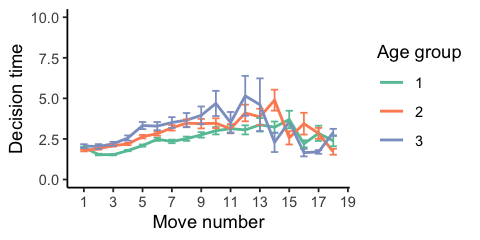

In [4]:

options(repr.plot.width=4, repr.plot.height=2)
p <- ggplot(df_rt, aes(x = MoveNr, y = RT, color = f_ageGroup, fill = f_ageGroup)) + 
  stat_summary(fun.y=mean, geom="line", size =0.8) +
  stat_summary(fun.data=mean_se, geom="errorbar", width = 0.5) + 
  labs(x = "Move number", y = "Decision time", color = "Age group") +
  theme_classic() +
  ylim(0,15)+
  coord_cartesian( ylim = c(0, 10))+
  scale_x_continuous(breaks=seq(1,37,2))+
 scale_colour_manual(values = c("#66c2a5", "#fc8d62", "#8da0cb"))

p

# Relation age and metrics

## Relation between age and elo

In [5]:
meanMetrics$s_ExactAge <- scale(meanMetrics$ExactAge)
lin_elo_model <- lm(elo ~ s_ExactAge, data = meanMetrics)
quad_elo_model <- lm(elo ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)
# check which is best
anova(lin_elo_model, quad_elo_model)

#answer: it's quadratic

# is there a linear or quadtratic effect of age on PD?
tab_model(quad_elo_model)
#answer: yes, both

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
154,2293003,NA,NA,NA,NA
153,2180073,1,112929.3,7.925504,0.005516116


## Relation between age and planning depth

In [16]:
lin_pd_model <- lm(planningDepth ~ s_ExactAge, data = meanMetrics)
quad_pd_model <- lm(planningDepth ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)
log_pd_model <- lm(planningDepth ~ scale(log(ExactAge)), data = meanMetrics)

# check which is best
anova(lin_pd_model, quad_pd_model)

#answer: it's linear

# is there a linear or quadtratic effect of age on PD?
tab_model(quad_pd_model)
#answer: yes, only linear

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
155,1094.147,NA,NA,NA,NA
154,1091.613,1,2.534652,0.3575776,0.550733


## Relation between age and heuristic quality in mean metrics

In [4]:
meanMetrics$s_ExactAge <- scale(meanMetrics$ExactAge)

lin_hq_model <- lm(heuristicQuality ~ s_ExactAge, data = meanMetrics)
quad_hq_model <- lm(heuristicQuality ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)
log_hq_model <- lm(heuristicQuality ~ scale(log(ExactAge)), data = meanMetrics)

#lin_gen_hq_model <- lm(heuristicQuality ~ gender + s_ExactAge, data = meanMetrics)
#quad_gen_hq_model <- lm(heuristicQuality ~ gender + poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)

# check which is best
anova(lin_hq_model, quad_hq_model)

#answer: it's quad_hq_model

# is there a linear or quadtratic effect of age on heuristic quality?
tab_model(quad_hq_model)
#answer: yes, both

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
155,2.152624,NA,NA,NA,NA
154,2.049656,1,0.102968,7.736457,0.006088118


## Relation between age and feature drop 

In [18]:
lin_fd_model <- lm(featureDropRate ~ s_ExactAge, data = meanMetrics)
quad_fd_model <- lm(featureDropRate ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = meanMetrics)
log_fd_model <- lm(featureDropRate ~ scale(log(ExactAge)), data = meanMetrics)

# check which is best
anova(lin_fd_model, quad_fd_model)

#answer: it's linear

# is there a linear or quadtratic effect of age on FD?
tab_model(quad_fd_model)
#answer: no

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
155,2.371120,NA,NA,NA,NA
154,2.357696,1,0.01342348,0.876795,0.3505471


# Robust Regressions age and metrics


Call:
lm(formula = elo ~ s_ExactAge, data = df_excl)

Residuals:
    Min      1Q  Median      3Q     Max 
-324.26  -87.94   16.41   86.50  283.00 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   94.609      9.770   9.684  < 2e-16 ***
s_ExactAge    47.632      9.801   4.860 2.87e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 122 on 154 degrees of freedom
Multiple R-squared:  0.133,	Adjusted R-squared:  0.1273 
F-statistic: 23.62 on 1 and 154 DF,  p-value: 2.868e-06


,Group.1,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,s_ExactAge,d1,r
8,139,3,0.6936697,0.0632455608,0.28746419,-194,139,NA,NA,10.0219,10,NA,NA,0,-1.158100,0.02841574,-1.927707
65,423,3,14.8322680,0.0002968112,0.04221531,-187,423,NA,NA,8.3260,8,NA,NA,0,-1.490136,0.03221497,-1.744336
77,811,3,4.7568000,0.2319220000,0.50786882,252,811,NA,NA,8.8658,8,NA,NA,0,-1.384450,0.03266394,1.847698
83,844,3,14.2126060,0.1238200000,0.12181901,-205,844,NA,NA,10.0164,10,NA,NA,0,-1.159177,0.03117796,-2.018134
116,A1107,3,6.1466240,0.1044345940,0.20526471,-125,A1107,NA,NA,24.4247,24,NA,NA,2,1.661790,0.07626697,-2.478625
127,A1169,3,3.9926552,0.5698700000,0.51368323,-139,A1169,NA,NA,25.6575,25,NA,NA,2,1.903157,0.11169322,-2.697839
132,A1186,3,0.9844583,0.3851000000,0.27467816,-62,A1186,NA,NA,22.3479,22,NA,NA,2,1.255178,0.02694901,-1.788281


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
NA,2295465,NA,NA,NA,NA
NA,2181671,NA,113794.2,NA,NA



Call: rlm(formula = elo ~ poly(s_ExactAge, degree = 2, raw = TRUE), 
    data = df_excl, psi = psi.bisquare)
Residuals:
     Min       1Q   Median       3Q      Max 
-336.777  -87.218    6.315   84.762  264.604 

Coefficients:
                                          Value    Std. Error t value 
(Intercept)                               127.3113  14.7894     8.6083
poly(s_ExactAge, degree = 2, raw = TRUE)1  58.4644  10.3919     5.6260
poly(s_ExactAge, degree = 2, raw = TRUE)2 -30.7685  11.0596    -2.7821

Residual standard error: 127 on 153 degrees of freedom

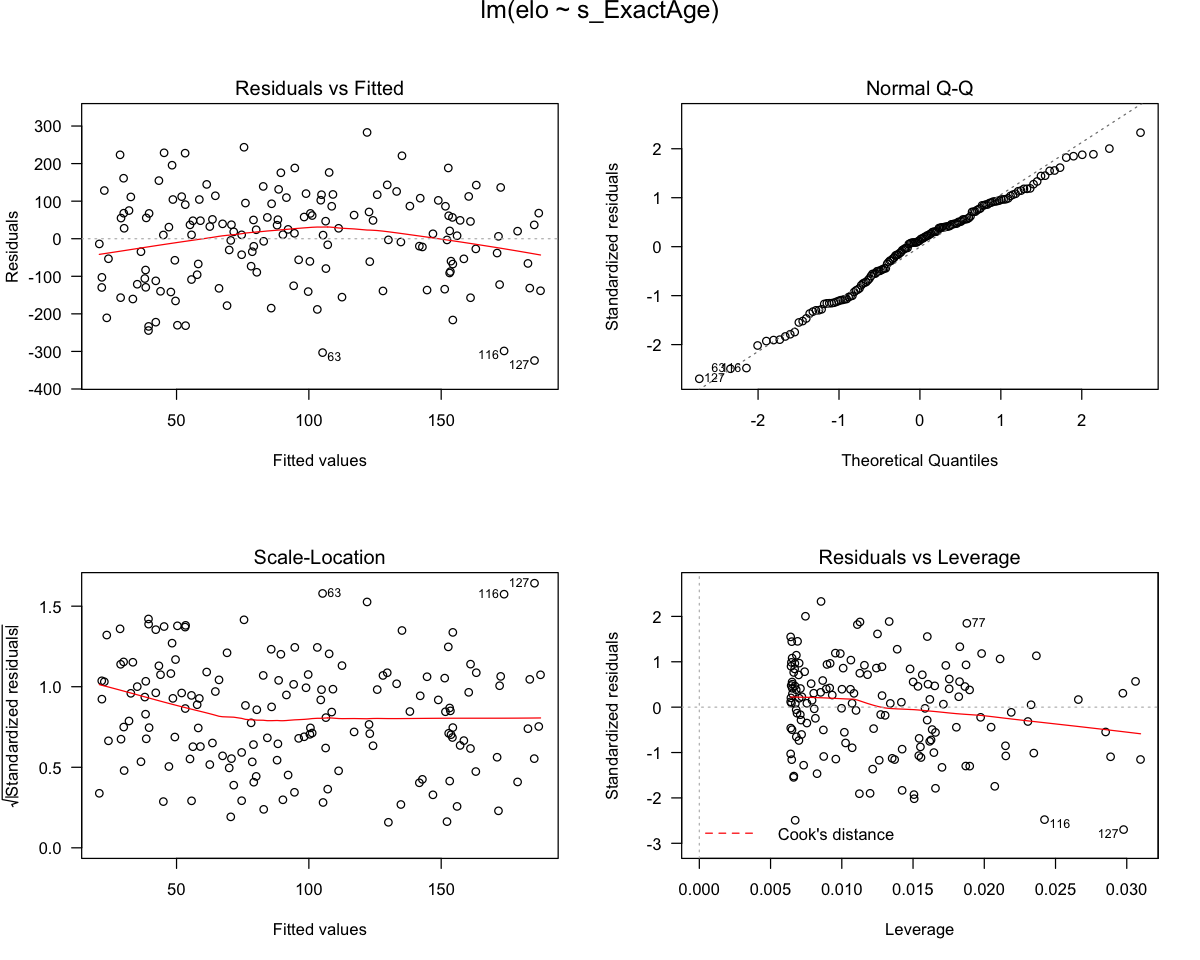

In [18]:
# Elo
summary(ols <- lm(elo ~ s_ExactAge, data = df_excl))
opar <- par(mfrow = c(2,2), oma = c(0, 0, 1.1, 0))
plot(ols, las = 1)
par(opar)
d1 <- cooks.distance(ols)
r <- stdres(ols)
a <- cbind(df_excl, d1, r)
a[d1 > 4/157, ] # 6 influential outliers based on cook's distance

#Robust regression
elo_lin.bisquare <- rlm(elo ~ s_ExactAge, data = df_excl, psi = psi.bisquare)
elo_poly.bisquare <- rlm(elo ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = df_excl, psi = psi.bisquare)
anova(elo_lin.bisquare, elo_poly.bisquare)
summary(elo_poly.bisquare)
tab_model(elo_poly.bisquare, p.style = "scientific", digits.p = 2)
# linear effect and quadratic effect of age on Elo


Call:
lm(formula = planningDepth ~ s_ExactAge, data = df_excl)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4879 -1.5512 -0.3066  1.1319 11.3522 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.7909     0.2073  23.113  < 2e-16 ***
s_ExactAge    0.5429     0.2079   2.611  0.00993 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.589 on 154 degrees of freedom
Multiple R-squared:  0.04238,	Adjusted R-squared:  0.03616 
F-statistic: 6.816 on 1 and 154 DF,  p-value: 0.00993


,Group.1,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,s_ExactAge,d1,r
63,372,3,16.2636780,7.357261e-05,0.05989027,-198,372,NA,NA,17.0712,17,NA,NA,1,0.2220655,0.06556531,4.399770
65,423,3,14.8322680,2.968112e-04,0.04221531,-187,423,NA,NA,8.3260,8,NA,NA,0,-1.4901361,0.18991057,4.235219
66,436,3,13.5295140,1.071960e-01,0.11510780,-127,436,NA,NA,9.3836,9,NA,NA,0,-1.2830711,0.11705892,3.675889
83,844,3,14.2126060,1.238200e-01,0.12181901,-205,844,NA,NA,10.0164,10,NA,NA,0,-1.1591767,0.11714681,3.911932
123,A1155,3,1.7353220,3.897180e-01,0.59809089,52,A1155,NA,NA,25.4658,25,NA,NA,2,1.8656241,0.03779233,-1.594658
132,A1186,3,0.9844583,3.851000e-01,0.27467816,-62,A1186,NA,NA,22.3479,22,NA,NA,2,1.2551779,0.02575000,-1.748046


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
NA,1062.068,NA,NA,NA,NA
NA,1071.331,NA,-9.263101,NA,NA



Call: rlm(formula = planningDepth ~ s_ExactAge, data = df_excl, psi = psi.bisquare)
Residuals:
     Min       1Q   Median       3Q      Max 
-4.52278 -1.18745  0.07749  1.42535 11.61672 

Coefficients:
            Value   Std. Error t value
(Intercept)  4.4620  0.1655    26.9564
s_ExactAge   0.8327  0.1661     5.0144

Residual standard error: 1.919 on 154 degrees of freedom

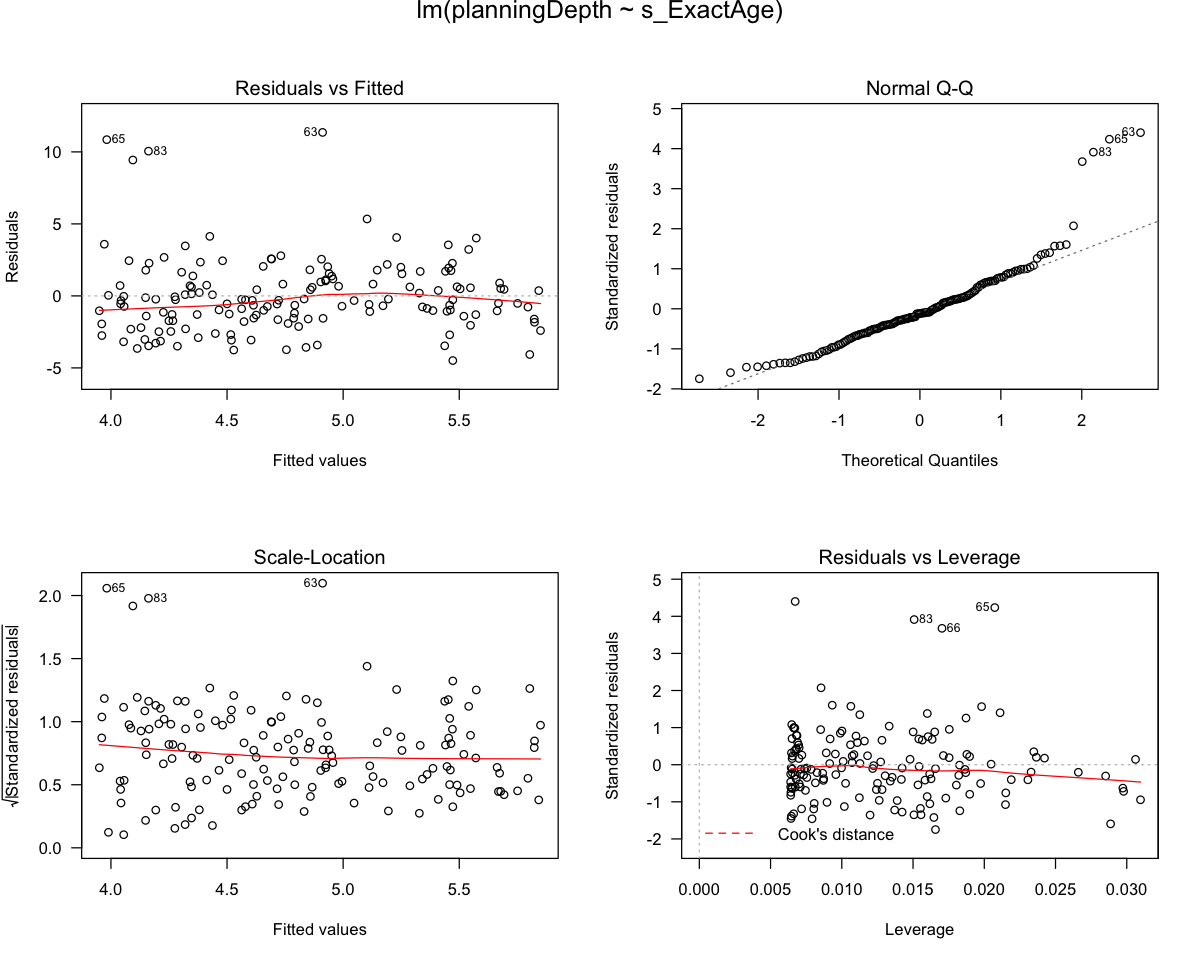

In [20]:
# Planning depth
summary(ols <- lm(planningDepth ~ s_ExactAge, data = df_excl))
opar <- par(mfrow = c(2,2), oma = c(0, 0, 1.1, 0))
plot(ols, las = 1)
par(opar)
d1 <- cooks.distance(ols)
r <- stdres(ols)
a <- cbind(df_excl, d1, r)
a[d1 > 4/157, ] # 6 influential outliers based on cook's distance

#Robust regression
pd_lin.bisquare <- rlm(planningDepth ~ s_ExactAge, data = df_excl, psi = psi.bisquare)
pd_poly.bisquare <- rlm(planningDepth ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = df_excl, psi = psi.bisquare)
anova(pd_lin.bisquare, pd_poly.bisquare)
summary(pd_lin.bisquare)
tab_model(pd_lin.bisquare, p.style = "scientific", digits.p = 2)
# linear effect of age on PD


Call:
lm(formula = heuristicQuality ~ s_ExactAge, data = df_excl)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44736 -0.02758  0.02412  0.06980  0.14563 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.485677   0.009204  52.767  < 2e-16 ***
s_ExactAge  0.036652   0.009234   3.969  0.00011 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.115 on 154 degrees of freedom
Multiple R-squared:  0.09281,	Adjusted R-squared:  0.08692 
F-statistic: 15.76 on 1 and 154 DF,  p-value: 0.0001103


,Group.1,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,s_ExactAge,d1,r
30,208,3,5.9327537,9.074200e-02,0.13919912,-91,208,NA,NA,9.9068,9,NA,NA,0,-1.1806351,0.05526302,-2.658011
53,290,3,3.3557181,1.238000e-05,0.04659144,115,290,NA,NA,17.0904,17,NA,NA,1,0.2258247,0.05172198,-3.904612
63,372,3,16.2636780,7.357261e-05,0.05989027,-198,372,NA,NA,17.0712,17,NA,NA,1,0.2220655,0.04858219,-3.787315
65,423,3,14.8322680,2.968112e-04,0.04221531,-187,423,NA,NA,8.3260,8,NA,NA,0,-1.4901361,0.12369432,-3.418033
66,436,3,13.5295140,1.071960e-01,0.11510780,-127,436,NA,NA,9.3836,9,NA,NA,0,-1.2830711,0.06980719,-2.838639
81,834,3,1.2070482,3.987780e-01,0.25267467,-81,834,NA,NA,8.1288,8,NA,NA,0,-1.5287454,0.02659102,-1.556205
83,844,3,14.2126060,1.238200e-01,0.12181901,-205,844,NA,NA,10.0164,10,NA,NA,0,-1.1591767,0.06073804,-2.816803
92,870,3,3.0855380,2.647320e-01,0.10349339,55,870,NA,NA,10.6192,10,NA,NA,0,-1.0411560,0.06165873,-3.012780
95,875,3,0.4620321,1.888018e-01,0.11658352,-86,875,NA,NA,9.5616,9,NA,NA,0,-1.2482209,0.06731376,-2.836078
116,A1107,3,6.1466240,1.044346e-01,0.20526471,-125,A1107,NA,NA,24.4247,24,NA,NA,2,1.6617896,0.11214776,-3.005646


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
NA,2.234469,NA,NA,NA,NA
NA,2.100256,NA,0.1342129,NA,NA



Call: rlm(formula = heuristicQuality ~ poly(s_ExactAge, degree = 2, 
    raw = TRUE), data = df_excl, psi = psi.bisquare)
Residuals:
      Min        1Q    Median        3Q       Max 
-0.491729 -0.052434  0.003212  0.041622  0.106037 

Coefficients:
                                          Value   Std. Error t value
(Intercept)                                0.5328  0.0078    68.2069
poly(s_ExactAge, degree = 2, raw = TRUE)1  0.0287  0.0055     5.2349
poly(s_ExactAge, degree = 2, raw = TRUE)2 -0.0181  0.0058    -3.0983

Residual standard error: 0.07117 on 153 degrees of freedom

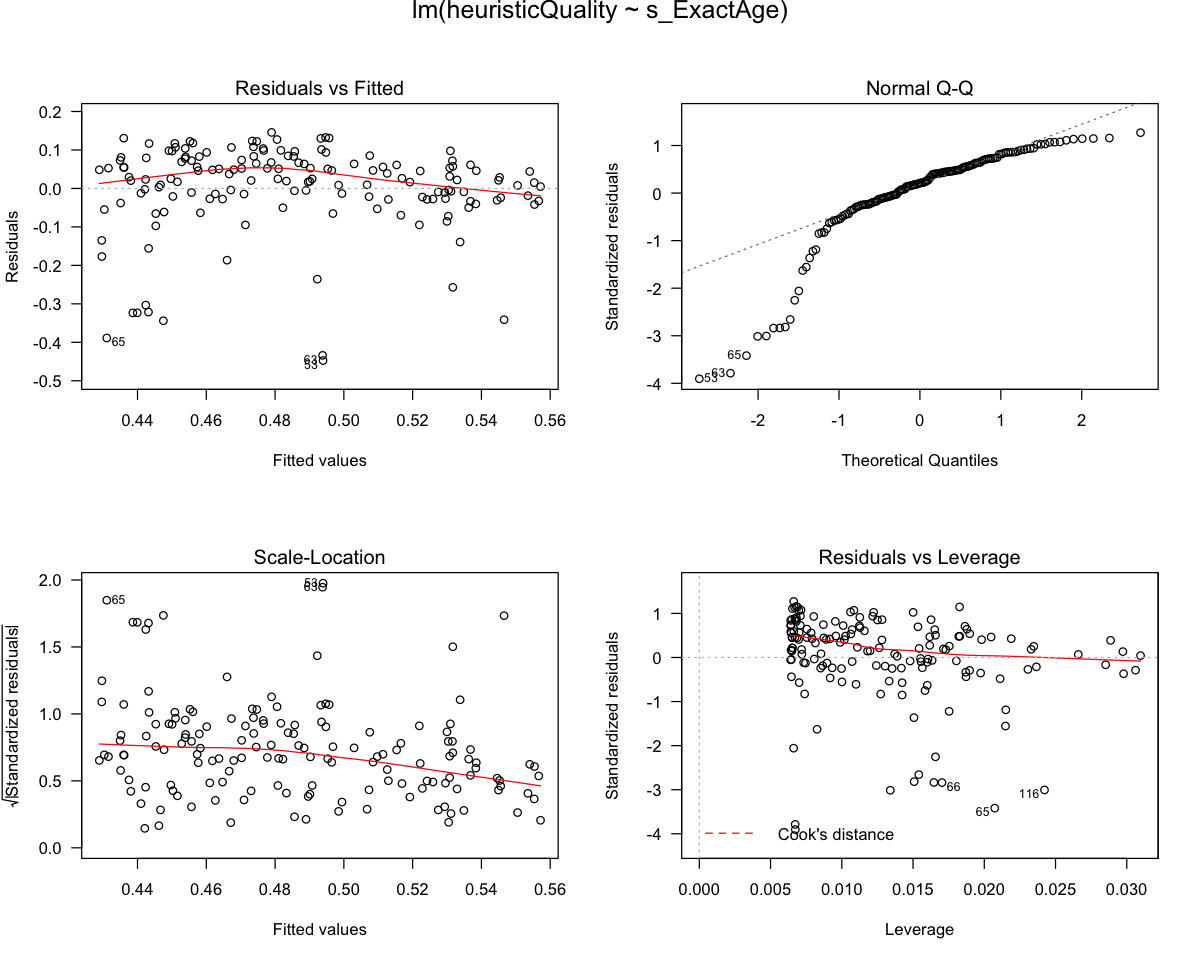

In [21]:
# Heuristic quality
summary(ols <- lm(heuristicQuality ~ s_ExactAge, data = df_excl))
opar <- par(mfrow = c(2,2), oma = c(0, 0, 1.1, 0))
plot(ols, las = 1)
par(opar)
d1 <- cooks.distance(ols)
r <- stdres(ols)
a <- cbind(df_excl, d1, r)
a[d1 > 4/157, ] # 6 influential outliers based on cook's distance

#Robust regression
hq_lin.bisquare <- rlm(heuristicQuality ~ s_ExactAge, data = df_excl, psi = psi.bisquare)
hq_poly.bisquare <- rlm(heuristicQuality ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = df_excl, psi = psi.bisquare)
anova(hq_lin.bisquare, hq_poly.bisquare)
summary(hq_poly.bisquare)
tab_model(hq_poly.bisquare, p.style = "scientific", digits.p = 2)
# linear effect of age on PD


Call:
lm(formula = featureDropRate ~ s_ExactAge, data = df_excl)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31528 -0.08393  0.00157  0.07903  0.32560 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.314627   0.009765  32.221   <2e-16 ***
s_ExactAge  0.002945   0.009796   0.301    0.764    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.122 on 154 degrees of freedom
Multiple R-squared:  0.0005867,	Adjusted R-squared:  -0.005903 
F-statistic: 0.0904 on 1 and 154 DF,  p-value: 0.7641


,Group.1,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,s_ExactAge,d1,r
8,139,3,0.6936697,0.0632455608,0.28746419,-194,139,NA,NA,10.0219,10,NA,NA,0,-1.1580999,0.03209450,-2.048693
30,208,3,5.9327537,0.0907420030,0.13919912,-91,208,NA,NA,9.9068,9,NA,NA,0,-1.1806351,0.02594646,-1.821287
65,423,3,14.8322680,0.0002968112,0.04221531,-187,423,NA,NA,8.3260,8,NA,NA,0,-1.4901361,0.06982626,-2.568093
75,806,3,4.0280520,0.5892460000,0.48431990,-29,806,NA,NA,8.3945,8,NA,NA,0,-1.4767246,0.05583859,2.311163
116,A1107,3,6.1466240,0.1044345940,0.20526471,-125,A1107,NA,NA,24.4247,24,NA,NA,2,1.6617896,0.03956909,-1.785339
127,A1169,3,3.9926552,0.5698700000,0.51368323,-139,A1169,NA,NA,25.6575,25,NA,NA,2,1.9031565,0.06626865,2.078053
137,A1203,3,5.9914280,0.6304480000,0.39453746,206,A1203,NA,NA,22.6438,22,NA,NA,2,1.3131115,0.05942556,2.580556
156,A953,3,5.5211860,0.6431420000,0.42717601,122,A953,NA,NA,20.9918,20,NA,NA,2,0.9896704,0.04654085,2.686881


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
NA,2.293634,NA,NA,NA,NA
NA,2.286772,NA,0.006862466,NA,NA



Call: rlm(formula = featureDropRate ~ s_ExactAge, data = df_excl, psi = psi.bisquare)
Residuals:
      Min        1Q    Median        3Q       Max 
-0.316728 -0.084321  0.001489  0.078666  0.329690 

Coefficients:
            Value   Std. Error t value
(Intercept)  0.3149  0.0098    32.0038
s_ExactAge  -0.0014  0.0099    -0.1460

Residual standard error: 0.1213 on 154 degrees of freedom

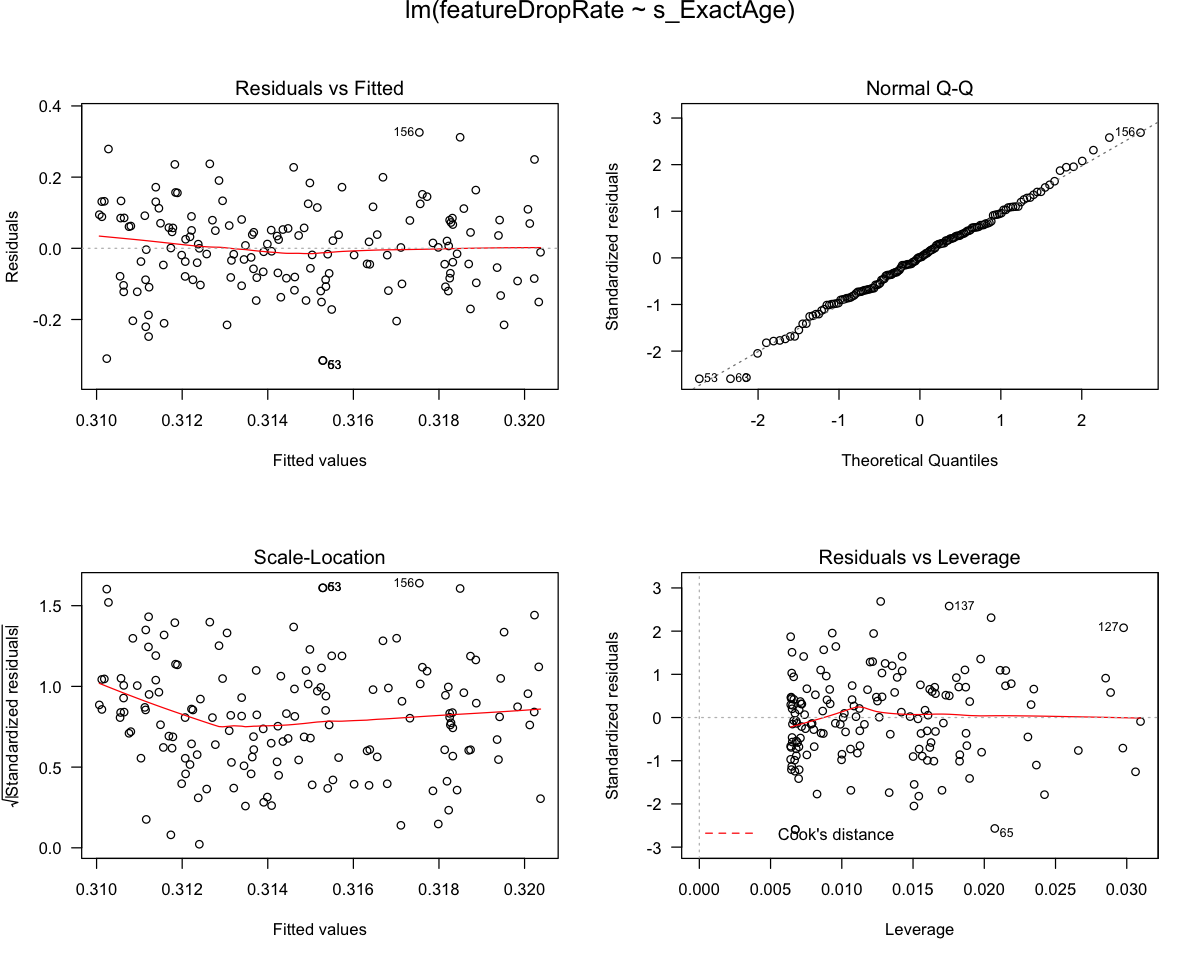

In [22]:
# Feature drop rate

summary(ols <- lm(featureDropRate ~ s_ExactAge, data = df_excl))
opar <- par(mfrow = c(2,2), oma = c(0, 0, 1.1, 0))
plot(ols, las = 1)
par(opar)
d1 <- cooks.distance(ols)
r <- stdres(ols)
a <- cbind(df_excl, d1, r)
a[d1 > 4/157, ] # 8 outliers found based on cook's distance

#Robust regression
fdr_lin.bisquare <- rlm(featureDropRate ~ s_ExactAge, data = df_excl, psi = psi.bisquare)
fdr_poly.bisquare <- rlm(featureDropRate ~ poly(s_ExactAge, degree = 2, raw = TRUE), data = df_excl, psi = psi.bisquare)
anova(fdr_lin.bisquare, fdr_poly.bisquare)
summary(fdr_lin.bisquare)
tab_model(fdr_lin.bisquare, p.style = "scientific", digits.p = 2)
# No effect of age on fdr

# Mixed models for relation between age and metrics

## Mixed effects models Age and planning depth

In [45]:
metrics$s_planningDepth <- scale(metrics$planningDepth)
metrics$s_featureDropRate <- scale(metrics$featureDropRate)
metrics$s_heuristicQuality <- scale(metrics$heuristicQuality)
metrics$s_elo <- scale(metrics$elo)
metrics$s_ExactAge <- scale(metrics$ExactAge)

pd_age <- lmer(planningDepth ~ s_ExactAge + (1|fold), data=metrics)
pd_agequad <- lmer(planningDepth ~ poly(s_ExactAge, degree = 2, raw = TRUE) + (1|fold), data=metrics)
pd_agegen <- lmer(planningDepth ~ s_ExactAge * as.factor(gender) + (1|fold), data=metrics)
pd_agequadgen <- lmer(planningDepth ~ poly(s_ExactAge, degree = 2, raw = TRUE) * as.factor(gender) + (1|fold), data=metrics)

anova(pd_age, pd_agequad) #linear is best. Adding gender improves the model. Esp for quadratic age * 
#summary(pd_age)
tab_model(pd_agequad)


boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
pd_age,4,4224.168,4242.831,-2108.084,4216.168,NA,NA,NA
pd_agequad,5,4225.161,4248.489,-2107.580,4215.161,1.007123,1,0.315593


## Mixed effects model age and HQ

In [20]:
hq_age <- lmer(heuristicQuality ~ s_ExactAge + (1|fold), data=metrics)
hq_agequad <- lmer(heuristicQuality ~ poly(s_ExactAge, degree = 2, raw = TRUE) + (1|fold), data=metrics)
hq_loggage <- lmer(heuristicQuality ~ scale(log(ExactAge)) + (1|fold), data=metrics)
hq_agegen <- lmer(heuristicQuality ~ s_ExactAge * as.factor(gender) + (1|fold), data=metrics)
hq_agequadgen <- lmer(heuristicQuality ~ poly(s_ExactAge, degree = 2, raw = TRUE)* as.factor(gender) + (1|fold), data=metrics)

anova(hq_age, hq_agequad) #linear is better, adding gender doesn't improve model
tab_model(hq_age)

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
hq_age,4,-1066.411,-1047.92,537.2055,-1074.411,NA,NA,NA
hq_agequad,5,-1089.643,-1066.53,549.8216,-1099.643,25.23209,1,5.08294e-07


## Mixed effects model Age and feature drop 

In [21]:
fd_age <- lmer(featureDropRate ~ s_ExactAge + (1|fold), data=metrics)
fd_agequad <- lmer(featureDropRate ~ poly(s_ExactAge, degree = 2, raw = TRUE) + (1|fold), data=metrics)
fd_logage <- lmer(featureDropRate ~ scale(log(ExactAge)) + (1|fold), data=metrics)
fd_agegen <- lmer(featureDropRate ~ s_ExactAge * as.factor(gender) + (1|fold), data=metrics)
fd_agequadgen <- lmer(featureDropRate ~ poly(s_ExactAge, degree = 2, raw = TRUE) * as.factor(gender) + (1|fold), data=metrics)

anova(fd_age, fd_agequad) #linear, adding gender does not improve models
tab_model(fd_age)

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
fd_age,4,-641.0659,-622.5750,324.5330,-649.0659,NA,NA,NA
fd_agequad,5,-644.2788,-621.1651,327.1394,-654.2788,5.212902,1,0.02241989


# Relation between Elo and the mean model derived metrics 

## Regular ELO regression model on mean metrics

In [9]:
#shows interaction between age and planning depth and main effects for other metrics
elo_metrics <- lm(elo ~ s_ExactAge * (scale(planningDepth) + scale(heuristicQuality) + scale(featureDropRate)), data=meanMetrics)
tab_model(elo_metrics)

,fold,planningDepth,featureDropRate,heuristicQuality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue,s_ExactAge
43,3,12.206460,0.0000386,0.11452235,-483,12.2603,12,0,10,-0.7163787
64,3,16.263678,0.0000736,0.05989026,-198,17.0712,17,1,15,0.2270038
24,3,2.031765,0.3375120,0.53586132,-178,11.5205,11,0,10,-0.8614481
117,3,6.146624,0.1044346,0.20526471,-125,24.4247,24,2,21,1.6689717


,fold,planningDepth,featureDropRate,heuristicQuality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue,s_ExactAge,d1,r
8,3,0.6936697,0.06324556,0.28746419,-194,10.0219,10,0,10,-1.1553126,0.08542550,-1.935237
43,3,12.2064600,0.00003860,0.11452235,-483,12.2603,12,0,10,-0.7163787,0.25739201,-4.080826
54,3,3.3557181,0.00001240,0.04659144,115,17.0904,17,1,15,0.2307688,0.12538592,2.007681
64,3,16.2636780,0.00007360,0.05989026,-198,17.0712,17,1,15,0.2270038,0.42800189,-2.949985
117,3,6.1466240,0.10443459,0.20526471,-125,24.4247,24,2,21,1.6689717,0.35696377,-2.438605
128,3,3.9926552,0.56987000,0.51368323,-139,25.6575,25,2,21,1.9107148,0.08847088,-2.016494
138,3,5.9914280,0.63044800,0.39453746,206,22.6438,22,2,21,1.3197501,0.08725567,1.734177


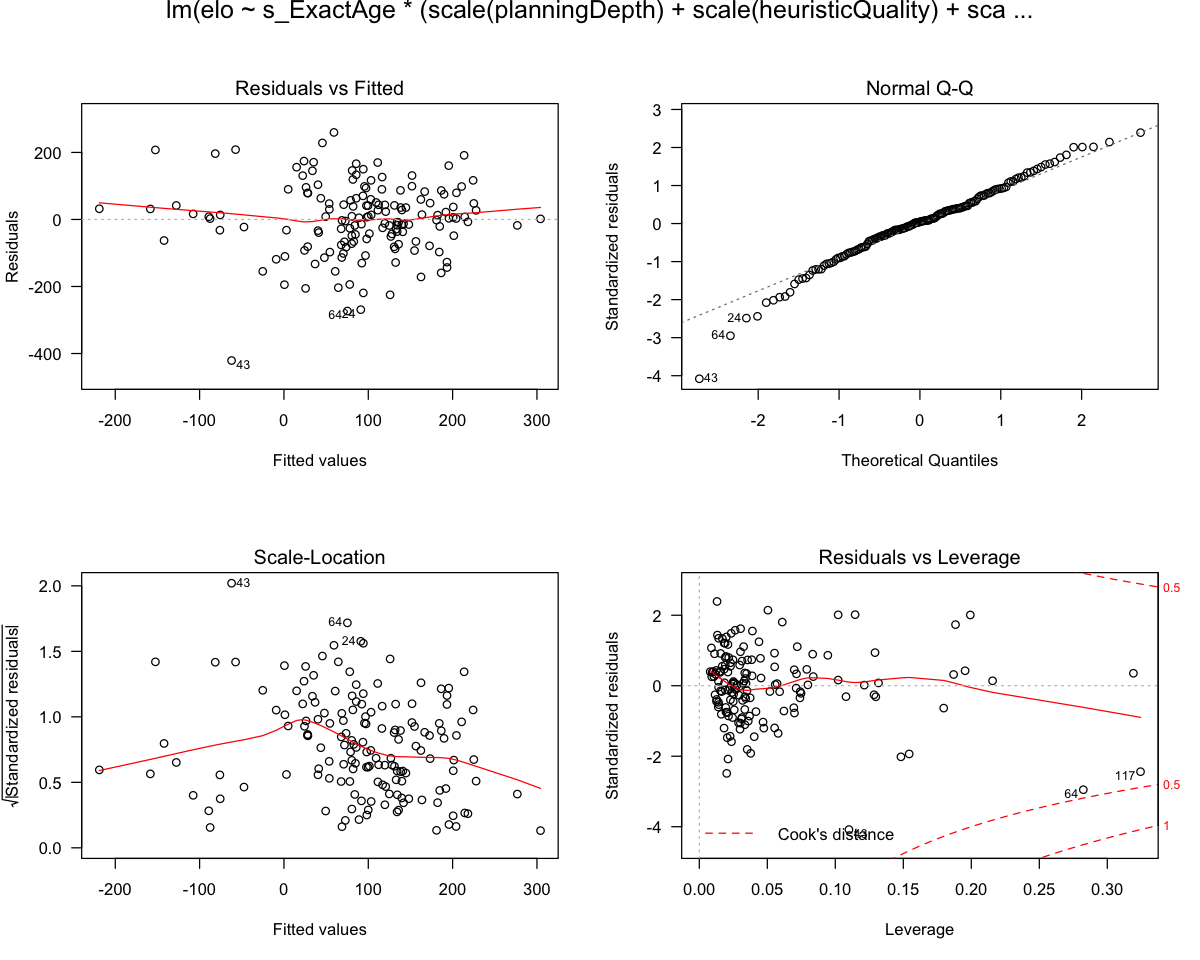

In [20]:
opar <- par(mfrow = c(2,2), oma = c(0, 0, 1.1, 0))
plot(elo_metrics, las = 1)
par(opar)
meanMetrics[c(43, 64, 24, 117), ]

d1 <- cooks.distance(elo_metrics)
r <- stdres(elo_metrics)
a <- cbind(meanMetrics, d1, r)
a[d1 > 4/51, ]

## Robust ELO regression model on mean metrics

In [24]:
elo_metrics_robust <- rlm(elo ~ s_ExactAge * (scale(planningDepth) + scale(heuristicQuality) + scale(featureDropRate)), data=df_excl, psi = psi.bisquare)
elo_metricsquad_robust <- rlm(elo ~ poly(s_ExactAge, degree = 2, raw = TRUE) * (scale(planningDepth) + scale(heuristicQuality) + scale(featureDropRate)), data=df_excl, psi = psi.bisquare)

#elo_metrics_robust$df.residual <- 151
#elo_metricsquad_robust$df.residual <- 152
anova(elo_metrics_robust, elo_metricsquad_robust)
summary(elo_metrics_robust)
tab_model(elo_metrics_robust, p.style = "scientific", digits.p = 2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
NA,1898766,NA,NA,NA,NA
NA,1970951,NA,-72185.03,NA,NA



Call: rlm(formula = elo ~ s_ExactAge * (scale(planningDepth) + scale(heuristicQuality) + 
    scale(featureDropRate)), data = df_excl, psi = psi.bisquare)
Residuals:
     Min       1Q   Median       3Q      Max 
-604.329  -55.029   -3.986   54.737  252.531 

Coefficients:
                                   Value    Std. Error t value 
(Intercept)                        106.8512   8.3993    12.7215
s_ExactAge                          32.9314   8.4952     3.8765
scale(planningDepth)                49.6530   8.9723     5.5340
scale(heuristicQuality)             25.2808   9.1144     2.7737
scale(featureDropRate)             -38.1884   8.3295    -4.5847
s_ExactAge:scale(planningDepth)     35.1726   8.8961     3.9537
s_ExactAge:scale(heuristicQuality) -38.8230   8.6644    -4.4807
s_ExactAge:scale(featureDropRate)   -4.0686   8.0803    -0.5035

Residual standard error: 81.88 on 148 degrees of freedom

In [25]:
df_excl_age1 <- df_excl[!(df_excl$ageBinNr=="1" | df_excl$ageBinNr=="2"),]
df_excl_age2 <- df_excl[!(df_excl$ageBinNr=="0" | df_excl$ageBinNr=="2"),]
df_excl_age3 <- df_excl[!(df_excl$ageBinNr=="0" | df_excl$ageBinNr=="1"),]

Robustmodel_followup <- function(df) {
    df$s_planningDepth <- scale(df$planningDepth)
    df$s_featureDropRate <- scale(df$featureDropRate)
    df$s_heuristicQuality <- scale(df$heuristicQuality)
    df$s_ExactAge <- scale(df$ExactAge)

    Elo_model_post_robust <- rlm(elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality, data=df, psi = psi.bisquare)
    table <- tab_model(Elo_model_post_robust, p.style = "scientific", digits.p = 2)
    return(table)
    }

Robustmodel_followup(df_excl_age1)
Robustmodel_followup(df_excl_age2)
Robustmodel_followup(df_excl_age3)

## Mixed effects model shows relation between Elo and the model derived metrics 

## Robust mixed effects model

In [46]:
#shows interaction between age and planning depth, and age and HQ. Main effects for pd, hq, and age but not fdr
Elo_modelfold_robust <- summary(rlmer(elo ~ s_ExactAge * (scale(planningDepth) + scale(featureDropRate) + scale(heuristicQuality)) +(1|fold), metrics))
#higher efficiency doesn't matter
rfm2 <- update(Elo_modelfold_robust, rho.sigma.e = psi2propII(smoothPsi, k = 2.28), rho.sigma.b = psi2propII(smoothPsi, k = 2.28))
compare(Elo_modelfold_robust, rfm2, show.rho.functions = FALSE)
plot(Elo_modelfold_robust)
tab_model(Elo_modelfold_robust)

boundary (singular) fit: see ?isSingular


In [27]:
head(metrics)

subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,⋯,TaskDate,ageBin,ageBinNr,ageBinValue,gender,s_ExactAge,s_planningDepth,s_featureDropRate,s_heuristicQuality,s_elo
101:R_31SM3mwQvAhBwar,1,6.67758,0.37914,0.4459566,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.8322211,0.3596428,-0.4044302,1.0143470
101:R_31SM3mwQvAhBwar,2,5.17404,0.40756,0.4295637,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.2920569,0.5403491,-0.5389408,1.0143470
101:R_31SM3mwQvAhBwar,3,6.41074,0.20175,0.4282075,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.7363557,-0.7682777,-0.5500687,1.0143470
101:R_31SM3mwQvAhBwar,4,6.03305,0.25907,0.4370336,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.6006662,-0.4038129,-0.4776468,1.0143470
101:R_31SM3mwQvAhBwar,5,6.37074,0.43755,0.4169013,227,101,5/19/03,F,17.4904,⋯,11/9/20,"(12, 17]",1,15,1,0.2957763,0.7219853,0.7310382,-0.6428401,1.0143470
102:R_vdABJ1XvXNriwff,1,9.34128,0.13684,0.6275961,179,102,11/12/05,F,15.0055,⋯,11/10/20,"(12, 17]",1,15,1,-0.1929323,1.7891862,-1.1810028,1.0859892,0.6374983


In [162]:
#Using folds as random effect shows interactions between age and planning depth and age and HQ and main effect fdr
Elo_modelfold <- lmer(elo ~ s_ExactAge * (scale(planningDepth) + scale(featureDropRate) + scale(heuristicQuality)) +(1|fold), data=metrics)
Elo_modelfold_quad <- lmer(elo ~ poly(s_ExactAge, degree = 2, raw = TRUE) * (scale(planningDepth) + scale(featureDropRate) + scale(heuristicQuality)) +(1|fold), data=metrics)

Elo_modelfoldgen <- lmer(elo ~ s_ExactAge * (scale(planningDepth) + scale(featureDropRate) + scale(heuristicQuality)) + as.factor(gender) +(1|fold), data=metrics)

anova(Elo_modelfold, Elo_modelfold_quad) # adding gender does not improve the model
summary(Elo_modelfold)
tab_model(Elo_modelfold_quad)


boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
refitting model(s) with ML (instead of REML)


,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
Elo_modelfold,10,9027.869,9073.963,-4503.935,9007.869,NA,NA,NA
Elo_modelfold_quad,14,9022.546,9087.077,-4497.273,8994.546,13.32314,4,0.00980019


Linear mixed model fit by REML ['lmerMod']
Formula: elo ~ s_ExactAge * (scale(planningDepth) + scale(featureDropRate) +  
    scale(heuristicQuality)) + (1 | fold)
   Data: metrics

REML criterion at convergence: 8971.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3653 -0.6083  0.0503  0.6826  2.9173 

Random effects:
 Groups   Name        Variance Std.Dev.
 fold     (Intercept)     0      0.0   
 Residual             11081    105.3   
Number of obs: 742, groups:  fold, 5

Fixed effects:
                                   Estimate Std. Error t value
(Intercept)                          99.670      4.090  24.367
s_ExactAge                           28.082      4.125   6.807
scale(planningDepth)                 34.185      4.055   8.430
scale(featureDropRate)              -25.329      3.888  -6.515
scale(heuristicQuality)              23.010      4.291   5.363
s_ExactAge:scale(planningDepth)       7.152      3.936   1.817
s_ExactAge:scale(featureDropRate)    -3.809    

### follow-up on significant interaction effects

In [126]:
# re-run the mixed model per age group
## first subset the dataframe
metrics_age1 <- metrics[!(metrics$ageBinNr=="1" | metrics$ageBinNr=="2"),]
metrics_age2 <- metrics[!(metrics$ageBinNr=="0" | metrics$ageBinNr=="2"),]
metrics_age3 <- metrics[!(metrics$ageBinNr=="0" | metrics$ageBinNr=="1"),]

mixedmodel_followup <- function(df) {
    df$s_planningDepth <- scale(df$planningDepth)
    df$s_featureDropRate <- scale(df$featureDropRate)
    df$s_heuristicQuality <- scale(df$heuristicQuality)
    df$s_ExactAge <- scale(df$ExactAge)

    Elo_modelfold <- lmer(elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality + (1|fold), data=df)
    table <- tab_model(Elo_modelfold)
    return(table)
    }

mixedmodel_followup(metrics_age1)
mixedmodel_followup(metrics_age2)
mixedmodel_followup(metrics_age3)

boundary (singular) fit: see ?isSingular


boundary (singular) fit: see ?isSingular


boundary (singular) fit: see ?isSingular


In [61]:
#Using the mean across folds returns roughly the same results
meanMetrics_age1 <- meanMetrics[!(meanMetrics$ageBinNr=="1" | meanMetrics$ageBinNr=="2"),]
meanMetrics_age2 <- meanMetrics[!(meanMetrics$ageBinNr=="0" | meanMetrics$ageBinNr=="2"),]
meanMetrics_age3 <- meanMetrics[!(meanMetrics$ageBinNr=="0" | meanMetrics$ageBinNr=="1"),]

regmodel_followup <- function(df) {
    df$s_planningDepth <- scale(df$planningDepth)
    df$s_featureDropRate <- scale(df$featureDropRate)
    df$s_heuristicQuality <- scale(df$heuristicQuality)
    df$s_ExactAge <- scale(df$ExactAge)

    Elo_regmodelfold <- lm(elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality, data=df)
    table <- tab_model(Elo_regmodelfold)
    return(table)
    }

regmodel_followup(meanMetrics_age1)
regmodel_followup(meanMetrics_age2)
regmodel_followup(meanMetrics_age3)

In [65]:
setwd("/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Analysis notebooks/data")
NLL <- read.csv('NLL.csv', header=TRUE)
NLL$fold <- as.factor(NLL$fold)

head(NLL)

nll,subject,fold,planning.depth,feature.drop.rate,heuristic.quality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
83.0405,101:R_31SM3mwQvAhBwar,1,6.67758,0.37914,0.4459566,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
95.7979,101:R_31SM3mwQvAhBwar,2,5.17404,0.40756,0.4295637,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
88.4858,101:R_31SM3mwQvAhBwar,3,6.41074,0.20175,0.4282075,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
82.0370,101:R_31SM3mwQvAhBwar,4,6.03305,0.25907,0.4370336,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
77.8444,101:R_31SM3mwQvAhBwar,5,6.37074,0.43755,0.4169013,227,101,5/19/03,F,17.4904,17,11/9/20,"(12.0, 17.0]",1,15
99.5031,102:R_vdABJ1XvXNriwff,1,9.34128,0.13684,0.6275961,179,102,11/12/05,F,15.0055,15,11/10/20,"(12.0, 17.0]",1,15


`geom_smooth()` using formula 'y ~ x'
Warning message:
“Removed 36 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 36 rows containing missing values (geom_point).”

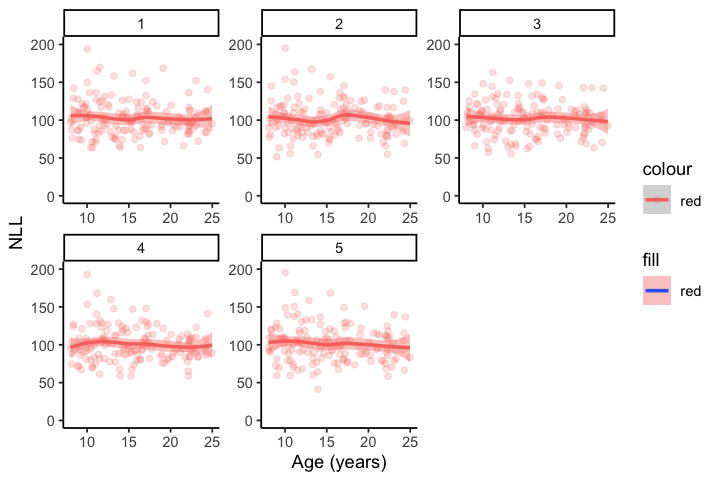

In [66]:
NLL <- NLL[!is.na(NLL$fold), ]
options(repr.plot.width=6, repr.plot.height=4)
P <- ggplot(NLL, aes(x=ExactAge, y=nll, color = "red")) + 
  geom_point(alpha = 0.2)+
  xlab("Age (years)") +
  ylab("NLL") +
  geom_smooth(method=loess, se = TRUE, aes(fill = "red")) +
facet_wrap(~ fold, scales='free') +
  theme_classic() +
    theme(axis.line=element_line()) + 
    scale_x_continuous(limits=c(8,25)) + scale_y_continuous(limits=c(0,200)) 
P

In [67]:
res2 <-cor.test(NLL$nll, NLL$ExactAge,  method = "spearman")
res2

Warning message in cor.test.default(NLL$nll, NLL$ExactAge, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  NLL$nll and NLL$ExactAge
S = 86263000, p-value = 0.05008
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.06995495 


In [186]:
head(df_rt2)
df_rt2 <- df_rt[!(df_rt$RT < 0),]
aggregate(df_rt2[, c('RT', 'ExactAge')], list(df_rt2$StudyID), mean)


StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBins,User,GameNr,Category,Level,MoveNr,RT,Result,ageGroup,f_ageGroup
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,0,2,12,1,2.197,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,0,2,12,2,1.247,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,0,2,12,3,1.062,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,0,2,12,4,0.866,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,1,3,22,1,2.551,win,3,3
A101,9/26/99,F,21.1151,21,11/1/20,"(18, 26]",A101:R_Q0Jd5lCBrQu5Dm9,1,3,22,2,4.436,win,3,3


Group.1,RT,ExactAge
101,1.520286,17.4904
102,2.722740,15.0055
107,3.079647,12.7260
117,1.803640,15.9315
121,2.043000,14.4055
129,2.001449,14.2712
137,3.770086,11.0849
139,1.902011,10.0219
149,2.195737,11.7616
150,1.667912,11.7589


# Model fit stability
## is there a relation between age and nll in any of the folds?

In [13]:
setwd("/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Analysis notebooks/data")
df_fit1 <- read.csv('paramsMatrixRepeat.csv', header=TRUE)
df_fit2 <- read.csv('paramsMatrixRepeat2.csv', header=TRUE)

head(df_fit1)


,X,subject,fold,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
,<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,101:R_31SM3mwQvAhBwar,1,8.4623,0.0010226,0.41862,0.050000,0.32047,1.9040,1.63420,0.86914,9.7910,10.0000
2,1,101:R_31SM3mwQvAhBwar,2,10.0000,0.0014914,0.52124,0.050000,0.69611,2.2852,1.16460,-0.51880,9.9548,9.4189
3,2,101:R_31SM3mwQvAhBwar,3,9.9555,0.0010716,0.44696,0.050146,1.15080,2.1910,1.59740,-0.33365,7.6202,9.6281
4,3,101:R_31SM3mwQvAhBwar,4,9.8418,0.0010000,0.44760,0.050000,0.87344,1.7751,1.09500,-0.65591,6.5770,9.0735
5,4,101:R_31SM3mwQvAhBwar,5,8.8168,0.0010068,0.41125,0.050395,0.25006,1.6626,0.70068,0.29663,8.8062,-8.4875
6,5,102:R_vdABJ1XvXNriwff,1,1.7767,0.0011454,0.38862,0.052138,0.69064,0.2517,1.33210,0.92464,4.9692,9.1711


In [14]:

meanMetrics <- read.csv('meanMetrics.csv', header=TRUE)
head(meanMetrics)
meanMetrics$s_planningDepth <- scale(meanMetrics$planningDepth)
meanMetrics$s_featureDropRate <- scale(meanMetrics$featureDropRate)
meanMetrics$s_heuristicQuality <- scale(meanMetrics$heuristicQuality)

Elo_model <- lm(elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality, data=meanMetrics)
summary(Elo_model)
tab_model(Elo_model)

,subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>
1,101:R_31SM3mwQvAhBwar,3,6.133230,0.3370140,0.4315325,227,17.4904,17,1,15
2,102:R_vdABJ1XvXNriwff,3,7.249400,0.3057720,0.6246183,179,15.0055,15,1,15
3,107:R_2ahKzS67s2u094R,3,1.835382,0.3623840,0.4482810,179,12.7260,12,0,10
4,117:R_2XpQzVOPaMJjkCo,3,3.590356,0.1968608,0.4794924,109,15.9315,15,1,15
5,121:R_2zoxitKzRuYUblm,3,5.059394,0.2312880,0.5969120,-9,14.4055,14,1,15
6,129:R_2q8z9DfvMUHDZio,3,3.963848,0.2560160,0.5818686,129,14.2712,14,1,15



Call:
lm(formula = elo ~ s_planningDepth + s_featureDropRate + s_heuristicQuality, 
    data = meanMetrics)

Residuals:
    Min      1Q  Median      3Q     Max 
-269.79  -70.78    9.54   67.26  254.31 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          94.609      8.643  10.946  < 2e-16 ***
s_planningDepth      26.453      9.126   2.899  0.00430 ** 
s_featureDropRate   -29.795      9.336  -3.192  0.00172 ** 
s_heuristicQuality   73.024      9.021   8.095 1.71e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 108 on 152 degrees of freedom
Multiple R-squared:  0.3302,	Adjusted R-squared:  0.317 
F-statistic: 24.98 on 3 and 152 DF,  p-value: 3.393e-13


ERROR: Error in tab_model(Elo_model): could not find function "tab_model"


## Is the correlation between parameters re-fitted on the same held-in data and validated on the same held-out data comparable to Bas' paper?

In [15]:
# function to create correlation dataframes
df_create_corrplot <- function(correlation) {
    parameter <- c("Pruning", "Stopping", "FeatureDrop", "Lapse", "C", "w center", "w twoCon", "w twoUncon", "w threeCon", "w fourCon")
    df <- data.frame(correlation, parameter)
    df$parameter <- factor(df$parameter,levels = c("w fourCon", "w threeCon", "w twoUncon", "w twoCon", "w center", "C",  "Lapse", "FeatureDrop", "Stopping", "Pruning"))
    return(df)
}

# Copy correlation coefficients from python notebook into a vector
allsubjlist <- c(0.682,
0.736,
0.786,
0.457,
0.808,
0.917,
0.742,
0.775,
0.538,
0.475)

childlist <- c(0.694,
0.818,
0.832,
0.625,
0.850,
0.822,
0.730,
0.654,
0.610,
0.590)

adollist <- c(0.597,
0.650,
0.728,
0.346,
0.719,
0.949,
0.694,
0.678,
0.535,
0.461)

adultlist <- c(0.759,
0.659,
0.765,
0.257,
0.764,
0.987,
0.819,
0.926,
0.488,
0.391)

# create correlation df across age
df <- df_create_corrplot(allsubjlist)

# create correlation df children
df_children <- df_create_corrplot(childlist)

# create correlation df adolescents
df_adol <- df_create_corrplot(adollist)

# create correlation df adults
df_adult <- df_create_corrplot(adultlist)


In [30]:
# create function to make correlation plots
corrplot <- function(dataframe, color) {
   # options(repr.plot.width=3.2, repr.plot.height=2)
    p <- ggplot(data=dataframe, aes(y=parameter, x=correlation)) +
    geom_bar(stat="identity", fill = color) +
    labs(x = "Correlation", y = "") +
    theme(panel.background = element_rect(fill = "white", colour = "white", size = 0.5, linetype = "solid"),
          axis.title = element_text(size = 11), axis.line = element_line(colour = "black"), text = element_text(size=11,colour="#262626")) +
    scale_x_continuous(limits=c(0, 1), breaks=seq(0,1,0.2)) 
    return(p)
}

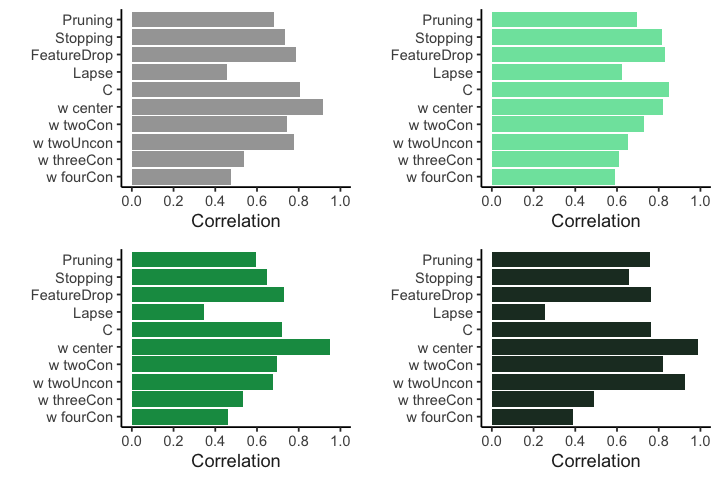

In [31]:
# create correlation plots

options(repr.plot.width=6, repr.plot.height =4)
require(gridExtra)
p1 <- corrplot(df, "#a5a5a5")
p2 <- corrplot(df_children, "#7DE3AC")
p3 <- corrplot(df_adol, "#129951")
p4 <- corrplot(df_adult, "#20382B")

grid.arrange(p1, p2, p3, p4, ncol=2, nrow = 2)

In [32]:
#Save the figure above to Pdf
pdf("Final_refitcorrelations.pdf", width = 6, height = 4) # Open a new pdf file
grid.arrange(p1, p2, p3, p4, ncol=2, nrow = 2) # Write the grid.arrange in the file
dev.off() # Close the file
#graph <- grid.arrange(p1, p2, p3, p4, ncol=2, nrow = 2) #also tried this way but rendering did not look as nice in overleaf
#ggsave(graph, filename = "graphtest.pdf", device = cairo_pdf, width = 6, height = 4)


pdf 
  2

## correlations between model derived metrics

In [129]:
sd(meanMetrics$ExactAge)

[1] 5.099628

In [127]:
head(meanMetrics)
cor.test(x=meanMetrics$heuristicQuality, y=meanMetrics$featureDropRate, method = 'spearman')

Group.1,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,s_ExactAge
101,3,6.133230,0.3370140,0.4315325,227,101,NA,NA,17.4904,17,NA,NA,1,0.309205880
102,3,7.249400,0.3057720,0.6246183,179,102,NA,NA,15.0055,15,NA,NA,1,-0.178064935
107,3,1.835382,0.3623840,0.4482810,179,107,NA,NA,12.7260,12,NA,NA,0,-0.625058305
117,3,3.590356,0.1968608,0.4794924,109,117,NA,NA,15.9315,15,NA,NA,1,0.003516929
121,3,5.059394,0.2312880,0.5969120,-9,121,NA,NA,14.4055,14,NA,NA,1,-0.295720571
129,3,3.963848,0.2560160,0.5818686,129,129,NA,NA,14.2712,14,NA,NA,1,-0.322055824



	Spearman's rank correlation rho

data:  meanMetrics$heuristicQuality and meanMetrics$featureDropRate
S = 665590, p-value = 0.6905
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.03199598 


# Individual differences: FOS and BIS-11

In [201]:
head(fos)

StudyID,fos_total,ExactAge
A112,43,19.6904
A121,43,19.7370
A101,37,21.1151
A1083,46,23.0630
A103,41,20.2438
A130,45,22.0493


In [101]:
setwd("/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Analysis notebooks/data")
fos <- read.csv('fos_only.csv', header=TRUE)
#Exclude for fos due to always responding with same button: A1107, 423
fos<-fos[!(fos$StudyID=="423" | fos$StudyID=="A1107" | fos$StudyID=="236"),]

bis <- read.csv('Bis_only.csv', header=TRUE)
#Exclude for bis due to always responding with same button: 149, A1107, A1068, 423
bis<-bis[!(bis$StudyID=="149" | bis$StudyID=="A1107" | bis$StudyID=="A1068"| bis$StudyID=="423"),]

#Metrics_mean <- read.csv('meanMetrics.csv', header=TRUE)
#fos_bis <- merge(fos, bis, by="StudyID")
#meanMetrics2 <- aggregate(Metrics[, 2:6], list(Metrics$StudyID), mean)
#meanMetrics2$StudyID <- meanMetrics2$Group.1
fos_metrics <- merge(fos, meanMetrics, by="StudyID")
bis_metrics <- merge(bis, meanMetrics, by="StudyID")

fos_bis <- merge(fos_metrics, bis_metrics, by="StudyID")

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


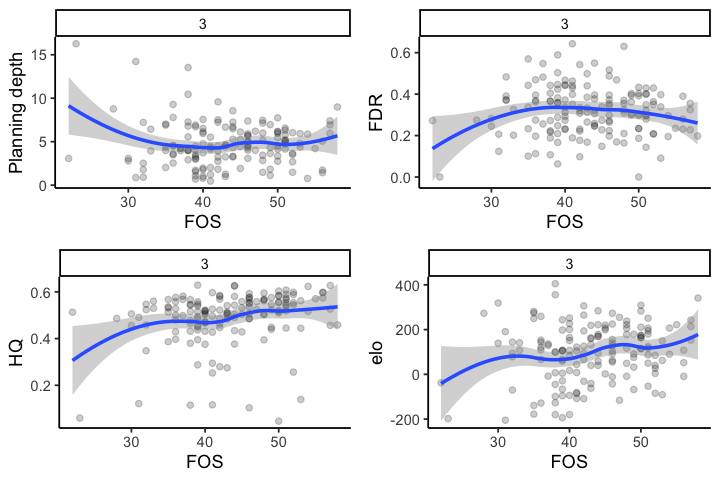

In [99]:

options(repr.plot.width=6, repr.plot.height=4)
pd <- ggplot(fos_metrics, aes(x=fos_total, y=planningDepth)) + 
  geom_point(alpha = 0.2)+
  xlab("FOS") +
  ylab("Planning depth") +
  geom_smooth(method=loess, se = TRUE) +
facet_wrap(~ fold, scales='free') +
  theme_classic()

options(repr.plot.width=6, repr.plot.height=4)
fdr <- ggplot(fos_metrics, aes(x=fos_total, y=featureDropRate)) + 
  geom_point(alpha = 0.2)+
  xlab("FOS") +
  ylab("FDR") +
  geom_smooth(method=loess, se = TRUE) +
facet_wrap(~ fold, scales='free') +
  theme_classic()  

options(repr.plot.width=6, repr.plot.height=4)
hq <- ggplot(fos_metrics, aes(x=fos_total, y=heuristicQuality)) + 
  geom_point(alpha = 0.2)+
  xlab("FOS") +
  ylab("HQ") +
  geom_smooth(method=loess, se = TRUE) +
facet_wrap(~ fold, scales='free') +
  theme_classic() 

options(repr.plot.width=6, repr.plot.height=4)
elo <- ggplot(fos_metrics, aes(x=fos_total, y=elo)) + 
  geom_point(alpha = 0.2)+
  xlab("FOS") +
  ylab("elo") +
  geom_smooth(method=loess, se = TRUE) +
facet_wrap(~ fold, scales='free') +
  theme_classic() 

grid.arrange(pd, fdr, hq, elo, ncol=2)

In [35]:
# is PD predicted by the FOS and BIS?
fos_bis2$s_ExactAge <- scale(fos_bis2$ExactAge)
fos_bis2$s_fos_total <- scale(fos_bis2$fos_total)
fos_bis2$s_bis_total <- scale(fos_bis2$bis_total)

fos_bis2$s_planning_subtotal <- scale(fos_bis2$planning_subtotal)
fos_bis2$s_anticipation_subtotal <- scale(fos_bis2$anticipation_subtotal)
fos_bis2$s_time_subtotal <- scale(fos_bis2$time_subtotal)

PD_Model <- rlm(planningDepth ~ s_fos_total + s_bis_total + s_ExactAge, data=fos_bis2, , psi = psi.bisquare)
summary(PD_Model)# show results
tab_model(PD_Model)


Call: rlm(formula = planningDepth ~ s_fos_total + s_bis_total + s_ExactAge, 
    data = fos_bis2, psi = psi.bisquare)
Residuals:
     Min       1Q   Median       3Q      Max 
-4.50801 -1.18838 -0.02032  1.45895 11.75735 

Coefficients:
            Value   Std. Error t value
(Intercept)  4.4768  0.1642    27.2597
s_fos_total -0.0362  0.1964    -0.1844
s_bis_total -0.1226  0.1869    -0.6557
s_ExactAge   0.8498  0.1752     4.8504

Residual standard error: 1.968 on 151 degrees of freedom

In [36]:
# is HQ predicted by the FOS and BIS?
fos_bis2$s_ExactAge <- scale(fos_bis2$ExactAge)
fos_bis2$s_fos_total <- scale(fos_bis2$fos_total)
fos_bis2$s_bis_total <- scale(fos_bis2$bis_total)

PD_Model <- lm(heuristicQuality ~ s_fos_total + s_bis_total + s_ExactAge, data=fos_bis2)
summary(PD_Model)# show results
tab_model(PD_Model)


Call:
lm(formula = heuristicQuality ~ s_fos_total + s_bis_total + s_ExactAge, 
    data = fos_bis2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46649 -0.02779  0.02308  0.07105  0.14912 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.487038   0.009058  53.771  < 2e-16 ***
s_fos_total  0.015450   0.010832   1.426 0.155847    
s_bis_total -0.005478   0.010310  -0.531 0.595983    
s_ExactAge   0.032597   0.009663   3.373 0.000944 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1128 on 151 degrees of freedom
Multiple R-squared:  0.1267,	Adjusted R-squared:  0.1093 
F-statistic: 7.302 on 3 and 151 DF,  p-value: 0.0001323


In [37]:
# is ELO predicted by the FOS and BIS?
fos_bis2$s_ExactAge <- scale(fos_bis2$ExactAge)
fos_bis2$s_fos_total <- scale(fos_bis2$fos_total)
fos_bis2$s_bis_total <- scale(fos_bis2$bis_total)

Elo_Model <- lm(elo ~ s_fos_total + s_bis_total + s_ExactAge, data=fos_bis2)
summary(Elo_Model)# show results
tab_model(Elo_Model)


Call:
lm(formula = elo ~ s_fos_total + s_bis_total + s_ExactAge, data = fos_bis2)

Residuals:
    Min      1Q  Median      3Q     Max 
-320.72  -78.76   13.65   83.42  292.66 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   95.619      9.759   9.798  < 2e-16 ***
s_fos_total    7.170     11.671   0.614    0.540    
s_bis_total   -5.395     11.108  -0.486    0.628    
s_ExactAge    46.050     10.411   4.423 1.85e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 121.5 on 151 degrees of freedom
Multiple R-squared:  0.1492,	Adjusted R-squared:  0.1323 
F-statistic: 8.829 on 3 and 151 DF,  p-value: 1.98e-05


In [38]:
# is Feature drop predicted by the FOS and BIS?
fos_bis2$s_ExactAge <- scale(fos_bis2$ExactAge)
fos_bis2$s_fos_total <- scale(fos_bis2$fos_total)
fos_bis2$s_bis_total <- scale(fos_bis2$bis_total)

fdr_Model <- lm(featureDropRate ~ s_fos_total + s_bis_total + s_ExactAge, data=fos_bis2)
summary(fdr_Model)# show results
tab_model(fdr_Model)


Call:
lm(formula = featureDropRate ~ s_fos_total + s_bis_total + s_ExactAge, 
    data = fos_bis2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.31572 -0.08380  0.00092  0.07922  0.32733 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.3141720  0.0098828  31.790   <2e-16 ***
s_fos_total  0.0010335  0.0118194   0.087    0.930    
s_bis_total -0.0001496  0.0112493  -0.013    0.989    
s_ExactAge   0.0020164  0.0105435   0.191    0.849    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.123 on 151 degrees of freedom
Multiple R-squared:  0.0004587,	Adjusted R-squared:  -0.0194 
F-statistic: 0.0231 on 3 and 151 DF,  p-value: 0.9952


In [124]:
corr <- cor.test(x=fos_bis2$fos_total, y=fos_bis2$heuristicQuality, method = 'spearman')
corr

Warning message in cor.test.default(x = fos_bis2$fos_total, y = fos_bis2$heuristicQuality, :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  fos_bis2$fos_total and fos_bis2$heuristicQuality
S = 468340, p-value = 0.001056
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2597882 


# check outlier planning depth

In [142]:
head(Metrics)

subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
101:R_31SM3mwQvAhBwar,1,6.67758,0.37914,0.4459566,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
101:R_31SM3mwQvAhBwar,2,5.17404,0.40756,0.4295637,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
101:R_31SM3mwQvAhBwar,3,6.41074,0.20175,0.4282075,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
101:R_31SM3mwQvAhBwar,4,6.03305,0.25907,0.4370336,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
101:R_31SM3mwQvAhBwar,5,6.37074,0.43755,0.4169013,227,101,5/19/03,F,17.4904,17,11/9/20,"(12, 17]",1,15
102:R_vdABJ1XvXNriwff,1,9.34128,0.13684,0.6275961,179,102,11/12/05,F,15.0055,15,11/10/20,"(12, 17]",1,15


In [159]:
meanMetrics2 %>%
    top_n(20, planningDepth)

Metrics %>%
    top_n(3, planningDepth)

Group.1,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID
102,3,7.249400,3.057720e-01,0.62461834,179,102
209,3,8.559386,5.499340e-01,0.43413134,95,209
236,3,12.206460,3.855800e-05,0.11452235,-483,236
372,3,16.263678,7.357261e-05,0.05989027,-198,372
423,3,14.832268,2.968112e-04,0.04221531,-187,423
436,3,13.529514,1.071960e-01,0.11510780,-127,436
449,3,7.456060,1.643024e-01,0.59471142,222,449
560,3,7.560000,4.422660e-01,0.37549744,151,560
844,3,14.212606,1.238200e-01,0.12181901,-205,844
883,3,7.269388,3.651320e-01,0.54644974,-99,883


subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
236:R_24qFUPTZKx0SybQ,5,19.7640,1.00e-04,0.08422408,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
372:R_Pwksr0eXcbCEd8d,5,20.1273,1.75e-05,-0.00489010,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
436:R_UYNV3EWWRV3lLoZ,4,19.9704,0.00e+00,-0.10391390,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10


In [160]:
filter(Metrics, StudyID ==236)
filter(Metrics, StudyID ==372)
filter(Metrics, StudyID ==436)

subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
236:R_24qFUPTZKx0SybQ,1,10.4260,8.19e-06,0.24035929,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
236:R_24qFUPTZKx0SybQ,2,0.0000,4.57e-05,0.13216281,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
236:R_24qFUPTZKx0SybQ,3,18.3042,2.29e-05,0.03867513,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
236:R_24qFUPTZKx0SybQ,4,12.5381,1.60e-05,0.07719043,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10
236:R_24qFUPTZKx0SybQ,5,19.7640,1.00e-04,0.08422408,-483,236,9/16/08,F,12.2603,12,12/17/20,"(7, 12]",0,10


subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
372:R_Pwksr0eXcbCEd8d,1,17.91720,7.9100e-05,0.05874636,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
372:R_Pwksr0eXcbCEd8d,2,17.29430,3.0400e-09,0.14878392,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
372:R_Pwksr0eXcbCEd8d,3,8.55339,1.0796e-04,0.13890093,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
372:R_Pwksr0eXcbCEd8d,4,17.42620,1.6330e-04,-0.04208978,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15
372:R_Pwksr0eXcbCEd8d,5,20.12730,1.7500e-05,-0.00489010,-198,372,3/31/04,M,17.0712,17,4/22/21,"(12, 17]",1,15


subject,fold,planningDepth,featureDropRate,heuristicQuality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
436:R_UYNV3EWWRV3lLoZ,1,19.54250,0.00078665,-0.000333426,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
436:R_UYNV3EWWRV3lLoZ,2,2.92421,0.53481000,0.385297557,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
436:R_UYNV3EWWRV3lLoZ,3,9.31366,0.00000641,0.227763972,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
436:R_UYNV3EWWRV3lLoZ,4,19.97040,0.00000000,-0.103913895,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10
436:R_UYNV3EWWRV3lLoZ,5,15.89680,0.00037703,0.066724769,-127,436,12/12/11,M,9.3836,9,4/28/21,"(7, 12]",0,10


# weighting opponent features

In [54]:
head(df_scale)

subject,fold,X1,X2,X3,X4,X5,X6,X7,X8,⋯,heuristic.quality,planning.depth,elo,opponentRatio,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate
101:R_31SM3mwQvAhBwar,3,5.886520,0.00136054,0.3370140,0.0502462,0.947092,1.8357400,0.764214,-0.2350068,⋯,0.4315325,6.133230,227,0.8995012,101,5/19/03,F,17.4904,17,11/9/20
102:R_vdABJ1XvXNriwff,3,6.499500,0.00387066,0.3057720,0.0536728,0.552488,0.1921220,1.456950,0.6889940,⋯,0.6246183,7.249400,179,0.3816811,102,11/12/05,F,15.0055,15,11/10/20
107:R_2ahKzS67s2u094R,3,2.303730,0.58255500,0.3623840,0.0733556,1.296060,0.2503182,1.147868,-0.7364780,⋯,0.4482810,1.835382,179,1.8411512,107,2/24/08,M,12.7260,12,11/12/20
117:R_2XpQzVOPaMJjkCo,3,3.799840,0.02642796,0.1968608,0.0533938,0.821404,0.5730420,0.875672,-0.9380372,⋯,0.4794924,3.590356,109,0.6969343,117,12/12/04,F,15.9315,15,11/13/20
121:R_2zoxitKzRuYUblm,3,3.712192,0.00596340,0.2312880,0.0730042,0.644920,0.4734680,1.178788,0.3952316,⋯,0.5969120,5.059394,-9,0.4759276,121,6/22/06,F,14.4055,14,11/13/20
129:R_2q8z9DfvMUHDZio,3,1.521042,0.06872380,0.2560160,0.0536320,0.903454,0.5774000,1.011628,0.7835440,⋯,0.5818686,3.963848,129,0.8239089,129,8/11/06,M,14.2712,14,11/14/20


In [65]:
oppweight_robust <- rlm(X5 ~ scale(ExactAge), data=df_scale, psi = psi.bisquare)
oppweight_robust_quad <- rlm(X5 ~ poly(scale(ExactAge), degree = 2, raw = TRUE), data=df_scale, psi = psi.bisquare)

#Examine the weights to determine the degrees of freedom
biweights <- data.frame(ExactAge = df_scale$ExactAge, resid = oppweight_robust_quad$resid, weight = oppweight_robust_quad$w)
biweights2 <- biweights[order(oppweight_robust_quad$w), ]
biweights2[1:15, ]

oppweight_robust$df.residual <- 149 # 6 weights are set to 0
oppweight_robust_quad$df.residual <- 148 # 6 weights are set to 0
anova(oppweight_robust, oppweight_robust_quad)
summary(oppweight_robust)
tab_model(oppweight_robust, p.style = "scientific", digits.p = 2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
149,39.40281,NA,NA,NA,NA
148,38.55186,1,0.8509501,3.266784,0.07272699



Call: rlm(formula = X5 ~ scale(ExactAge), data = df_scale, psi = psi.bisquare)
Residuals:
      Min        1Q    Median        3Q       Max 
-0.579424 -0.169928 -0.001371  0.193817  2.495289 

Coefficients:
                Value   Std. Error t value
(Intercept)      0.8833  0.0240    36.8740
scale(ExactAge) -0.0697  0.0240    -2.9020

Residual standard error: 0.2804 on 154 degrees of freedom

## Robust mediation

In [4]:
# load needed libraries
library(glue)
library(magrittr)
library(afex)
library(robmed)
library(diagram)
library(tidyverse)
library(sjPlot)

# define add age group function
addAgeGroup <- function(df, ageColumn){
  ageColumn <- enquo(ageColumn)
  df %>% mutate(age_group = case_when((!! ageColumn) < 13 ~ "Children",
                                      (!! ageColumn) >= 13 & (!! ageColumn) < 18 ~ "Adolescents",
                                      (!! ageColumn) >= 18 ~ "Adults"), 
                age_group = factor(age_group, levels = c("Children", "Adolescents", "Adults")))
}

# define new function so that scale returns a vector, not a matrix
scale_this <- function(x) as.vector(scale(x))

##################################
### 1. Process 4-in-a-row data ###
##################################

# read in model outputs
model_outputs <- read.csv("../data/4inarow_params.csv")

# clean up subject ids
model_outputs$subject_id <- sub("\\:.*", "", model_outputs$subject)

ERROR: Error in library(robmed): there is no package called ‘robmed’


In [3]:
install.packages("robmed")

also installing the dependencies ‘mnormt’, ‘sn’




  There are binary versions available but the source versions are later:
       binary source needs_compilation
mnormt  1.5-6  2.0.2              TRUE
sn      1.5-5  2.0.1             FALSE
robmed  0.6.0  0.9.0             FALSE



installing the source packages ‘mnormt’, ‘sn’, ‘robmed’

Warning message in install.packages("robmed"):
“installation of package ‘mnormt’ had non-zero exit status”Warning message in install.packages("robmed"):
“installation of package ‘sn’ had non-zero exit status”Warning message in install.packages("robmed"):
“installation of package ‘robmed’ had non-zero exit status”